# Transfer of dimensionless policies on the Half Cheetah

## Imports and setup

In [54]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import gymnasium as gym
from stable_baselines3 import SAC
from sb3_contrib import TQC
from huggingface_sb3 import load_from_hub
from tqdm.notebook import tqdm

from pipoli.core import Dimension, Context, DimensionalPolicy, ScaledPolicy
from pipoli.sources.sb3 import SB3Policy

from make_cheetah import make_cheetah_xml

# thanks to Tony Saad for pointing to this solution
# [http://www.tonysaad.net/code/vector-graphics-plots-using-matplotlib-in-jupyter/]
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

OUTDIR = Path("output")
XML_FILES = OUTDIR / "xml_files"
DATADIR = OUTDIR / "data"

OUTDIR.mkdir(exist_ok=True)
XML_FILES.mkdir(exist_ok=True)
DATADIR.mkdir(exist_ok=True)

## Original Half Cheetah

### Original context

In [55]:
base_dimensions = [
    M := Dimension([1, 0, 0]),
    L := Dimension([0, 1, 0]),
    T := Dimension([0, 0, 1]),
]
Unit = Dimension([0, 0, 0])

In [56]:
original_context = Context(
    base_dimensions,
    *zip(
        ("dt", T, 0.01),
        ("m", M, 14),
        ("g", L/T**2, 9.81),
        ("taumax", M*L**2/T**2, 1),
        ("d", L, 0.046),
        ("L", L, 0.5),
        ("Lh", L, 0.15),
        ("l0", L, 0.145),
        ("l1", L, 0.15),
        ("l2", L, 0.094),
        ("l3", L, 0.133),
        ("l4", L, 0.106),
        ("l5", L, 0.07),
        ("k0", M*L**2/T**2, 240),
        ("k1", M*L**2/T**2, 180),
        ("k2", M*L**2/T**2, 120),
        ("k3", M*L**2/T**2, 180),
        ("k4", M*L**2/T**2, 120),
        ("k5", M*L**2/T**2, 60),
        ("b0", M*L**2/T, 6),
        ("b1", M*L**2/T, 4.5),
        ("b2", M*L**2/T, 3),
        ("b3", M*L**2/T, 4.5),
        ("b4", M*L**2/T, 3),
        ("b5", M*L**2/T, 1.5),
    )
)
original_cheetah_file = make_cheetah_xml(original_context, "original", outdir=XML_FILES)

### Original policy instantiation

In [57]:
# halfcheetah_v5_sac_expert =  load_from_hub(
#     repo_id="farama-minari/HalfCheetah-v5-SAC-expert",
#     filename="halfcheetah-v5-sac-expert.zip",
# )
# model = SAC.load(halfcheetah_v5_sac_expert)

halfcheetah_v5_tqc_expert =  load_from_hub(
    repo_id="farama-minari/HalfCheetah-v5-TQC-expert",
    filename="halfcheetah-v5-TQC-expert.zip",
)
model = TQC.load(halfcheetah_v5_tqc_expert)

sb3_policy = SB3Policy(
    model,
    model_obs_space=gym.spaces.Box(-np.inf, np.inf, (17,), np.float64),
    model_act_space=gym.spaces.Box(-1.0, 1.0, (6,), np.float32),
    predict_kwargs=dict(deterministic=True)
)

original_policy = DimensionalPolicy(
    sb3_policy,
    original_context,
    obs_dims=[L] + [Unit] * 7 + [L/T] * 2 + [1/T] * 7,
    act_dims=[M*L**2/T**2] * 6
)

Visual validation that the policy works.

In [58]:
env = gym.make("HalfCheetah-v5", xml_file=original_cheetah_file, render_mode="human")
obs, _ = env.reset()

for _ in range(250):
    act = original_policy.action(obs)
    obs, _, _, _, _ = env.step(act)

env.close()

## Similar transfer study

### Data generation

#### Utilities

Hide this section for better legibility.

In [59]:
def make_context_sweep(context, base, range1, range2, range3, outdir="./output"):
    contexts = {}

    for b1 in range1:
        for b2 in range2:
            for b3 in range3:
                new_context = context.scale_to(base, [b1, b2, b3])
                xml_file = make_cheetah_xml(new_context, f"{b1:.2f}-{b2:.2f}-{b3:.2f}", outdir=outdir)

                contexts[xml_file] = new_context
    
    return contexts

In [60]:
def record_episode(env, policy, nb_steps, close=True):
    observations = np.zeros((nb_steps,) + env.observation_space.shape)
    actions = np.zeros((nb_steps,) + env.action_space.shape)
    infos = [None] * nb_steps
    rewards = np.zeros(nb_steps)

    obs, info = env.reset()
    act = policy.action(obs)

    for i in range(nb_steps):
        observations[i] = obs
        actions[i] = act

        obs, rew, _, trunc, info = env.step(act)
        act = policy.action(obs)

        rewards[i] = rew
        infos[i] = info

        if trunc:
            break
    
    if close:
        env.close()

    return observations, actions, rewards, infos, i, trunc

#### Make contexts

In [116]:
base = ["m", "L", "g"]

SPACE = "log"
GRID_SIZE = 20

if SPACE == "log":
    ms = np.logspace(-1, 1, num=GRID_SIZE) * original_context.value("m")
    Ls = np.logspace(-1, 1, num=GRID_SIZE) * original_context.value("L")
elif SPACE == "lin":
    ms = np.linspace(0.1, 10, num=GRID_SIZE) * original_context.value("m")
    Ls = np.linspace(0.1, 10, num=GRID_SIZE) * original_context.value("L")  
else:
    assert False, "wrong SPACE value"

gs = [original_context.value("g")]

all_contexts = make_context_sweep(original_context, base, ms, Ls, gs, outdir=XML_FILES)

#### Generate data

In [118]:
NB_STEPS = 500

df = pd.DataFrame(columns=["m", "L", "g", "context", "observations", "actions", "rewards", "infos", "last_step"])
df.attrs["max_steps"] = NB_STEPS
df.attrs["base"] = base

# original
m = original_context.value("m")
L_ = original_context.value("L")
g = original_context.value("g")
env = gym.make("HalfCheetah-v5", xml_file=original_cheetah_file, render_mode=None)
observations, actions, rewards, infos, last_step, trunc = record_episode(env, original_policy, NB_STEPS)
df.loc["original"] = [m, L_, g, original_context, observations, actions, rewards, infos, last_step]

# all others
for xml_file, context in tqdm(all_contexts.items()):
    m = context.value("m")
    L_ = context.value("L")
    g = context.value("g")

    env = gym.make("HalfCheetah-v5", xml_file=xml_file, render_mode=None)
    policy = original_policy.to_scaled(context=context, base=base)
    observations, actions, rewards, infos, last_step, trunc = record_episode(env, policy, NB_STEPS)

    index = xml_file.split("/")[-1].removesuffix(".xml")
    df.loc[index] = [m, L_, g, context, observations, actions, rewards, infos, last_step]

  0%|          | 0/400 [00:00<?, ?it/s]

In [119]:

df.to_pickle(DATADIR / f"data-{SPACE}-{GRID_SIZE}-{NB_STEPS}.pkl.gz")

### Data analysis

In [120]:
df = pd.read_pickle(DATADIR / f"data-{SPACE}-{GRID_SIZE}-{NB_STEPS}.pkl.gz")
# df = pd.read_pickle(DATADIR / f"all_data_20.pkl.gz")
base = df.attrs["base"]
df.attrs

{'max_steps': 500, 'base': ['m', 'L', 'g']}

#### Reward vs context distance analysis

In [121]:
def adim_reward_forward(context, infos):
    forward_reward_adim, _ = context.make_transforms([L / T], base)

    fwd_rews = np.array([forward_reward_adim(info["reward_forward"]) for info in infos])

    return fwd_rews

def adim_reward_ctrl(context, infos):
    control_cost_adim, _ = context.make_transforms([M*L**2/T**2], base)
    ctl_costs = np.array([control_cost_adim(info["reward_ctrl"]) for info in infos])

    return ctl_costs

In [122]:
def heatmap(df, x, y, C, /, title=None, xlabel=None, ylabel=None, zlabel=None, xscale="log", yscale="log", **kwargs):
    xs = np.array(df[x])
    ys = np.array(df[y])
    Cs = np.array(df[C])

    Nx = np.sqrt(xs.size).astype(int)
    Ny = np.sqrt(xs.size).astype(int)
    X = xs.reshape((Nx, Ny))
    Y = ys.reshape((Nx, Ny))
    Z = Cs.reshape((Nx, Ny))

    plt.figure()
    plt.pcolormesh(X, Y, Z, **kwargs)
    plt.yscale(xscale)
    plt.xscale(yscale)
    plt.title(title or "")
    plt.xlabel(xlabel or x)
    plt.ylabel(ylabel or y)
    plt.colorbar(label=zlabel or C)

Building the score dataframe.

In [123]:
score_df = df.sort_values(["m", "L"])[["m", "L", "context", "infos"]]

In [124]:
score_df["adimensional_distance_to_original"] = score_df["context"].map(lambda c: c.adimensional_distance(original_context, base))
score_df["cosine_similarity_to_original"] = score_df["context"].map(lambda c: c.cosine_similarity(original_context))
score_df["euclidian_distance_to_original"] = score_df["context"].map(lambda c: c.euclidian_distance(original_context))
score_df["rewards_forward"] = score_df.apply(lambda row: adim_reward_forward(row["context"], row["infos"]), axis=1)
score_df["rewards_ctrl"] = score_df.apply(lambda row: adim_reward_ctrl(row["context"], row["infos"]), axis=1)
score_df["rewards_total_per_step"] = score_df.apply(lambda row: row["rewards_forward"] + row["rewards_ctrl"], axis=1)
score_df["reward_forward_total"] = score_df["rewards_forward"].map(np.sum)
score_df["reward_ctrl_total"] = score_df["rewards_ctrl"].map(np.sum)
score_df["reward_total"] = score_df["rewards_total_per_step"].map(np.sum)
score_df["mean_reward_per_step"] = score_df["rewards_total_per_step"].map(np.mean)
score_df["std_reward_per_step"] = score_df["rewards_total_per_step"].map(np.std)
score_df["norm_std_reward_per_step"] = score_df["rewards_total_per_step"].map(lambda r: np.std(r) / np.abs(np.mean(r)))

In [125]:
final_score_df = score_df.drop(columns=["context", "infos", "rewards_forward", "rewards_ctrl", "rewards_total_per_step"])
final_score_df

,m,L,adimensional_distance_to_original,cosine_similarity_to_original,euclidian_distance_to_original,reward_forward_total,reward_ctrl_total,reward_total,mean_reward_per_step,std_reward_per_step,norm_std_reward_per_step
cheetah-1.40-0.05-9.81,1.4,0.050000,0.000000e+00,0.396211,389.840546,-1.522666,-0.020119,-1.542785,-0.003086,0.081581,26.439586
cheetah-1.40-0.06-9.81,1.4,0.063714,6.280370e-16,0.477458,388.761961,4.969876,-0.025504,4.944372,0.009889,0.071828,7.263637
cheetah-1.40-0.08-9.81,1.4,0.081189,7.632783e-17,0.566241,387.387495,6.118032,-0.034775,6.083257,0.012167,0.134342,11.041986
cheetah-1.40-0.10-9.81,1.4,0.103457,6.806132e-16,0.657070,385.635977,5.162602,-0.051762,5.110840,0.010222,0.116572,11.404366
cheetah-1.40-0.13-9.81,1.4,0.131833,5.551549e-16,0.742868,383.403960,30.401337,-0.044704,30.356633,0.060713,0.220110,3.625403
...,...,...,...,...,...,...,...,...,...,...,...
cheetah-140.00-1.90-9.81,140.0,1.896345,1.083890e-16,0.999083,14547.011705,859.623382,-65.107064,794.516317,1.589033,1.537532,0.967590
cheetah-140.00-2.42-9.81,140.0,2.416465,8.410958e-16,0.998857,18650.778574,1218.761803,-142.143263,1076.618539,2.153237,1.091880,0.507088
cheetah-140.00-3.08-9.81,140.0,3.079241,5.596466e-16,0.998573,23884.021260,1193.373190,-181.418962,1011.954227,2.023908,1.159880,0.573089
cheetah-140.00-3.92-9.81,140.0,3.923800,5.594315e-16,0.998207,30558.909918,1422.270350,-232.411754,1189.858596,2.379717,0.938249,0.394269


In [126]:
# final_score_df.to_csv(OUTDIR / "data.csv")

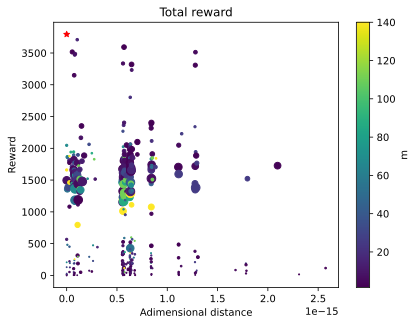

In [127]:
viz_df = final_score_df.sort_values(["adimensional_distance_to_original"])

viz_df.plot.scatter(
    x="adimensional_distance_to_original",
    y="reward_total",
    s=viz_df["L"]*15,
    c="m",
    xlabel="Adimensional distance",
    ylabel="Reward",
    title="Total reward",
    legend=False,
    # logx=True,
)
plt.scatter(0, final_score_df.loc["original"]["reward_total"], c="r", marker="*")

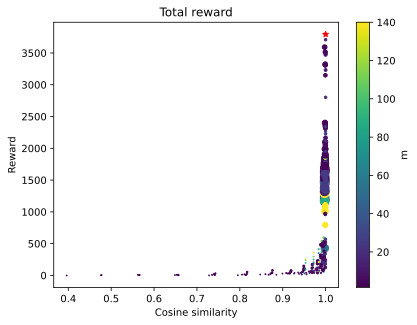

In [128]:
viz_df = final_score_df.sort_values(["adimensional_distance_to_original"])

viz_df.plot.scatter(
    x="cosine_similarity_to_original",
    y="reward_total",
    s=viz_df["L"]*15,
    c="m",
    xlabel="Cosine similarity",
    ylabel="Reward",
    title="Total reward",
    legend=False,
    # logx=True,
)
plt.scatter(1, final_score_df.loc["original"]["reward_total"], c="r", marker="*")

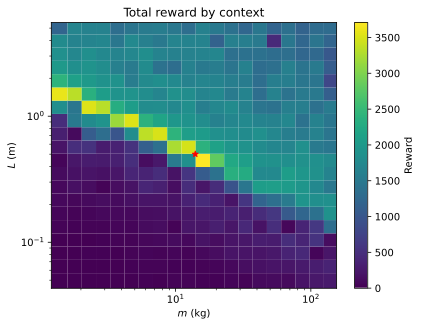

In [129]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "reward_total",
    title="Total reward by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="linear",
    # xscale="linear",
    # yscale="linear"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

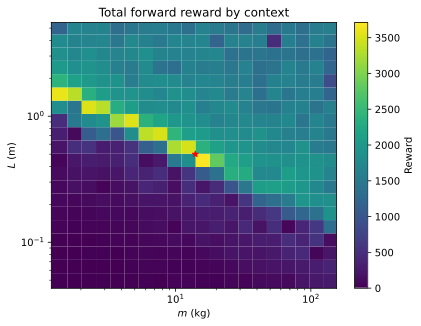

In [130]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "reward_forward_total",
    title="Total forward reward by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="linear",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

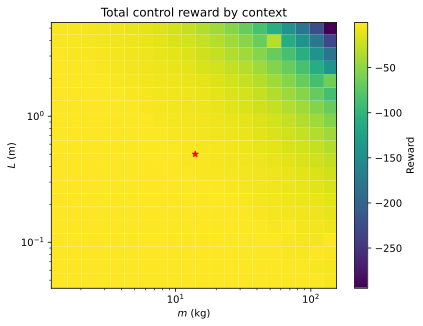

In [131]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "reward_ctrl_total",
    title="Total control reward by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="linear",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

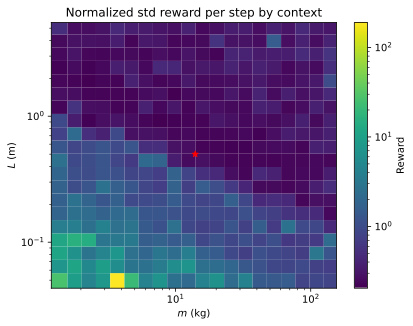

In [136]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "norm_std_reward_per_step",
    title="Normalized std reward per step by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="log",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

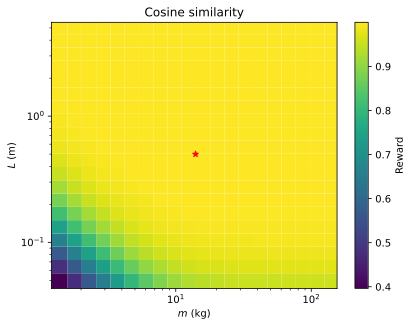

In [133]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "cosine_similarity_to_original",
    title="Cosine similarity",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="linear",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

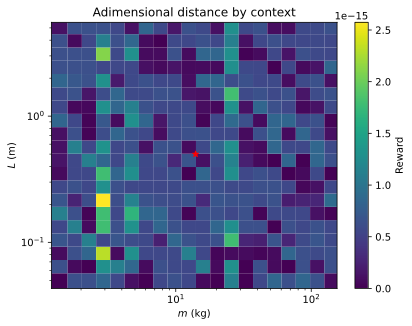

In [134]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "adimensional_distance_to_original",
    title="Adimensional distance by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="linear",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")

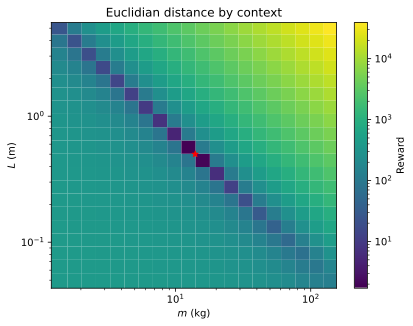

In [135]:
heatmap(
    final_score_df.drop("original").sort_values(["m", "L"]),
    "m",
    "L",
    "euclidian_distance_to_original",
    title="Euclidian distance by context",
    xlabel="$m$ (kg)",
    ylabel="$L$ (m)",
    zlabel="Reward",
    norm="log",
    # shading="gouraud"
)
plt.scatter(original_context.value("m"), original_context.value("L"), c="r", marker="*")